# Carregando Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregando sinais e Reconstrução

In [ ]:

def process_csv_to_2d_array(file_path):
    """
    Processa um arquivo CSV para criar uma matriz bidimensional.
    A primeira coluna será desconsiderada no processamento, mas não removida.
    
    Parâmetros:
        file_path (str): Caminho do arquivo CSV.
    
    Retorna:
        np.ndarray: Matriz 2D representando os dados do arquivo (desconsiderando a primeira coluna no final).
    """
    # Lê os dados do CSV com todas as colunas
    raw_data = pd.read_csv(file_path, header=None, dtype=str)
    
    
    # Remove linhas com NaN
    valid_data = raw_data.dropna()

    processed_data = []
    for _, row in valid_data.iterrows():
        try:
            # Converter cada célula em uma lista ou número
            processed_row = [eval(cell) if isinstance(cell, str) else cell for cell in row]
            flattened_row = np.hstack([np.array(value) if isinstance(value, list) else np.array([value]) for value in processed_row])
            processed_data.append(flattened_row)
        except Exception as e:
            print(f"Erro ao processar linha: {row.tolist()}. Erro: {e}")
            continue

    # Transforma os dados em array para trabalhar com matrizes
    data_array = np.array(processed_data)

    # Desconsiderar a primeira coluna no processamento
    data_array_without_first_col = data_array[:, 1:]  # Ignora a primeira coluna
    #print(f"Dimensões finais do arquivo {file_path}: {data_array_without_first_col.shape}")
    #print(f"Exemplo de dados no arquivo {file_path} (Após desconsiderar a primeira coluna): {raw_data.iloc[:3, 1:].values.tolist()}")
    
    return data_array_without_first_col

def reconstruct_iq_signals(i_files, q_files):
    """
    Reconstrói sinais complexos a partir de arquivos de componentes I e Q.
    """
    signals_complex = {}
    for idx, (i_file, q_file) in enumerate(zip(i_files, q_files)):
        print(f"Processando arquivos: {i_file} e {q_file}")
        I = process_csv_to_2d_array(i_file)
        Q = process_csv_to_2d_array(q_file)
        
        # Garantir alinhamento dimensional
        min_rows = min(I.shape[0], Q.shape[0])
        min_cols = min(I.shape[1], Q.shape[1])
        I_aligned = I[:min_rows, :min_cols]
        Q_aligned = Q[:min_rows, :min_cols]
        
        # Reconstruir o sinal complexo
        signals_complex[f"data_{idx}"] = I_aligned + 1j * Q_aligned
    return signals_complex

# Lista de arquivos
i_files = ["data_0_I.csv", "data_2_I.csv", "data_3_I.csv"]
q_files = ["data_0_Q.csv", "data_2_Q.csv", "data_3_Q.csv"]

# Reconstruir os sinais
try:
    signals_complex = reconstruct_iq_signals(i_files, q_files)
    for antenna, data in signals_complex.items():
        print(f"{antenna}: {data.shape} (linhas x colunas)")
except Exception as e:
    print(f"Erro durante a reconstrução dos sinais: {e}")

Processando arquivos: data_0_I.csv e data_0_Q.csv
Processando arquivos: data_2_I.csv e data_2_Q.csv
Processando arquivos: data_3_I.csv e data_3_Q.csv
data_0: (184, 512) (linhas x colunas)
data_1: (184, 512) (linhas x colunas)
data_2: (184, 512) (linhas x colunas)


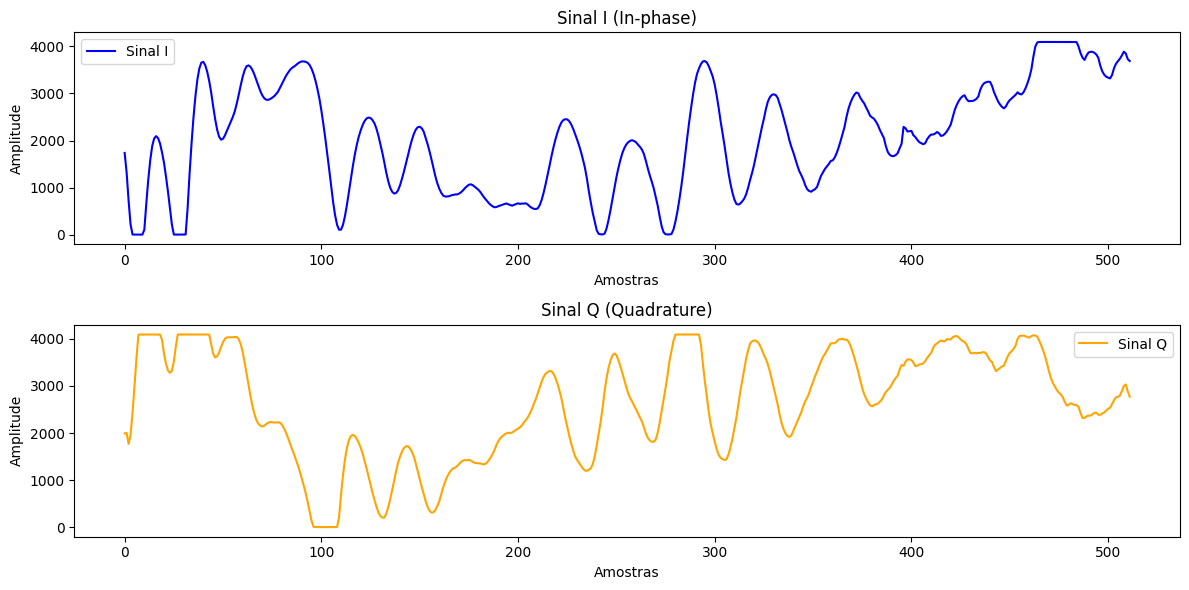

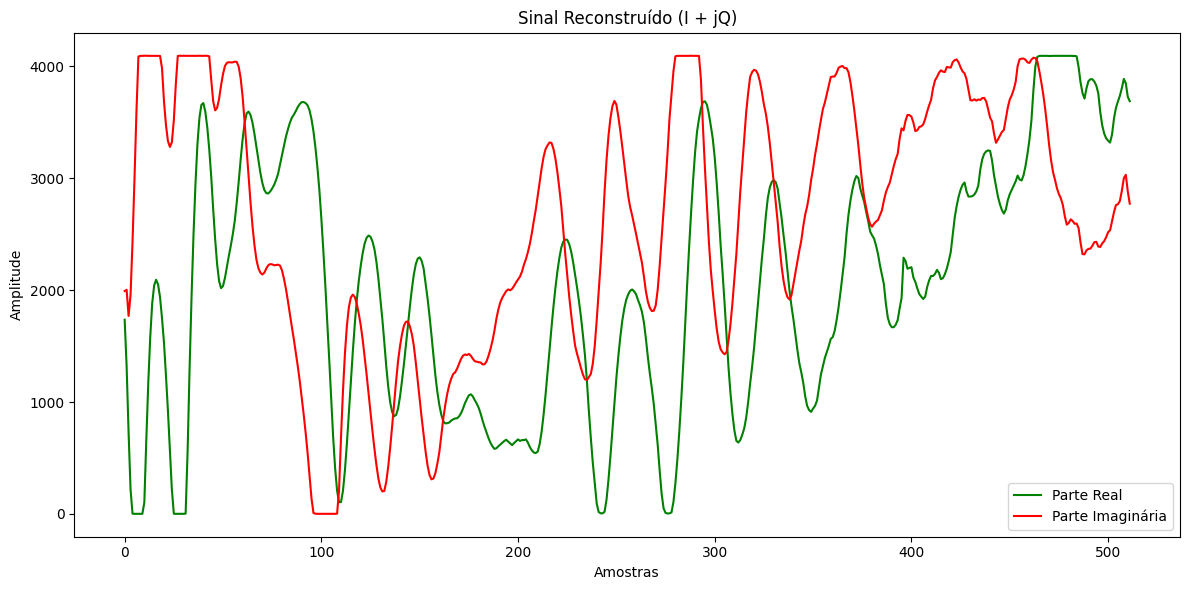

In [ ]:

# Selecionar um exemplo de sinal I e Q (antes da reconstrução)
i_example = process_csv_to_2d_array(i_files[0])[0, :]
q_example = process_csv_to_2d_array(q_files[0])[0, :]

# Sinal reconstruído (após combinação I + jQ)
reconstructed_signal = signals_complex["data_0"][0, :]

# Verificar visualmente os sinais I e Q separados
plt.figure(figsize=(12, 6))

# Gráfico 1: Apenas Sinal I
plt.subplot(2, 1, 1)
plt.plot(i_example, label='Sinal I', color='blue')
plt.title('Sinal I (In-phase)')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()

# Gráfico 2: Apenas Sinal Q
plt.subplot(2, 1, 2)
plt.plot(q_example, label='Sinal Q', color='orange')
plt.title('Sinal Q (Quadrature)')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

# Plotar o sinal reconstruído (I + jQ)
plt.figure(figsize=(12, 6))

# Parte Real e Imaginária do sinal reconstruído
plt.plot(reconstructed_signal.real, label='Parte Real', color='green')
plt.plot(reconstructed_signal.imag, label='Parte Imaginária', color='red')
plt.title('Sinal Reconstruído (I + jQ)')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


# Aplicando MIMO

In [36]:
def apply_mimo_channel(signal, num_tx=3, num_rx=3):
    """
    Aplica o canal MIMO ao sinal de entrada.
    """
    channel_matrix = np.random.randn(num_rx, num_tx) + 1j * np.random.randn(num_rx, num_tx)
    mimo_output = np.zeros((*signal.shape, num_tx * num_rx), dtype=complex)

    idx = 0
    for tx in range(num_tx):
        for rx in range(num_rx):
            mimo_output[:, :, idx] = signal * channel_matrix[rx, tx]
            idx += 1

    return mimo_output

# Configurar o sistema MIMO
num_tx, num_rx = 3, 3
combined_mimo_signal = np.zeros((184, 512, num_tx * num_rx, 2), dtype=complex)

tx_signals = [signals_complex["data_0"], signals_complex["data_1"], signals_complex["data_2"]]

for tx_idx, tx_signal in enumerate(tx_signals):
    for rx_idx in range(num_rx):
        mimo_combination = tx_signal * (np.random.randn(*tx_signal.shape) + 1j * np.random.randn(*tx_signal.shape))
        combined_mimo_signal[:, :, tx_idx * num_rx + rx_idx, :] = np.expand_dims(mimo_combination, axis=-1)

# Aplicação da FFT

In [35]:
def apply_fft_with_padding(data, fft_shape):
    """
    Aplica FFT 4D com zero-padding para alcançar a forma desejada.
    """
    fft_output = np.fft.fftshift(
        np.fft.fftn(
            data,  # Dados de entrada
            s=fft_shape,  # Zero-padding em Range e Doppler
            axes=(0, 1, 2, 3)  # FFT ao longo de Range, Doppler, TxRx e Elevation
        ),
        axes=(0, 1, 2, 3)  # Reorganizar frequências centradas
    )
    return np.abs(fft_output)  # Retornar a magnitude

# Aplicar FFT com zero-padding
fft_combined_signal = apply_fft_with_padding(combined_mimo_signal, fft_shape=(64,64,9,8))

# Verificar a forma final do sinal FFT
print("Forma da FFT combinada:", fft_combined_signal.shape)  # Deve ser (64, 64, 9, 8)

Forma da FFT combinada: (64, 64, 9, 8)


# Plotagem 

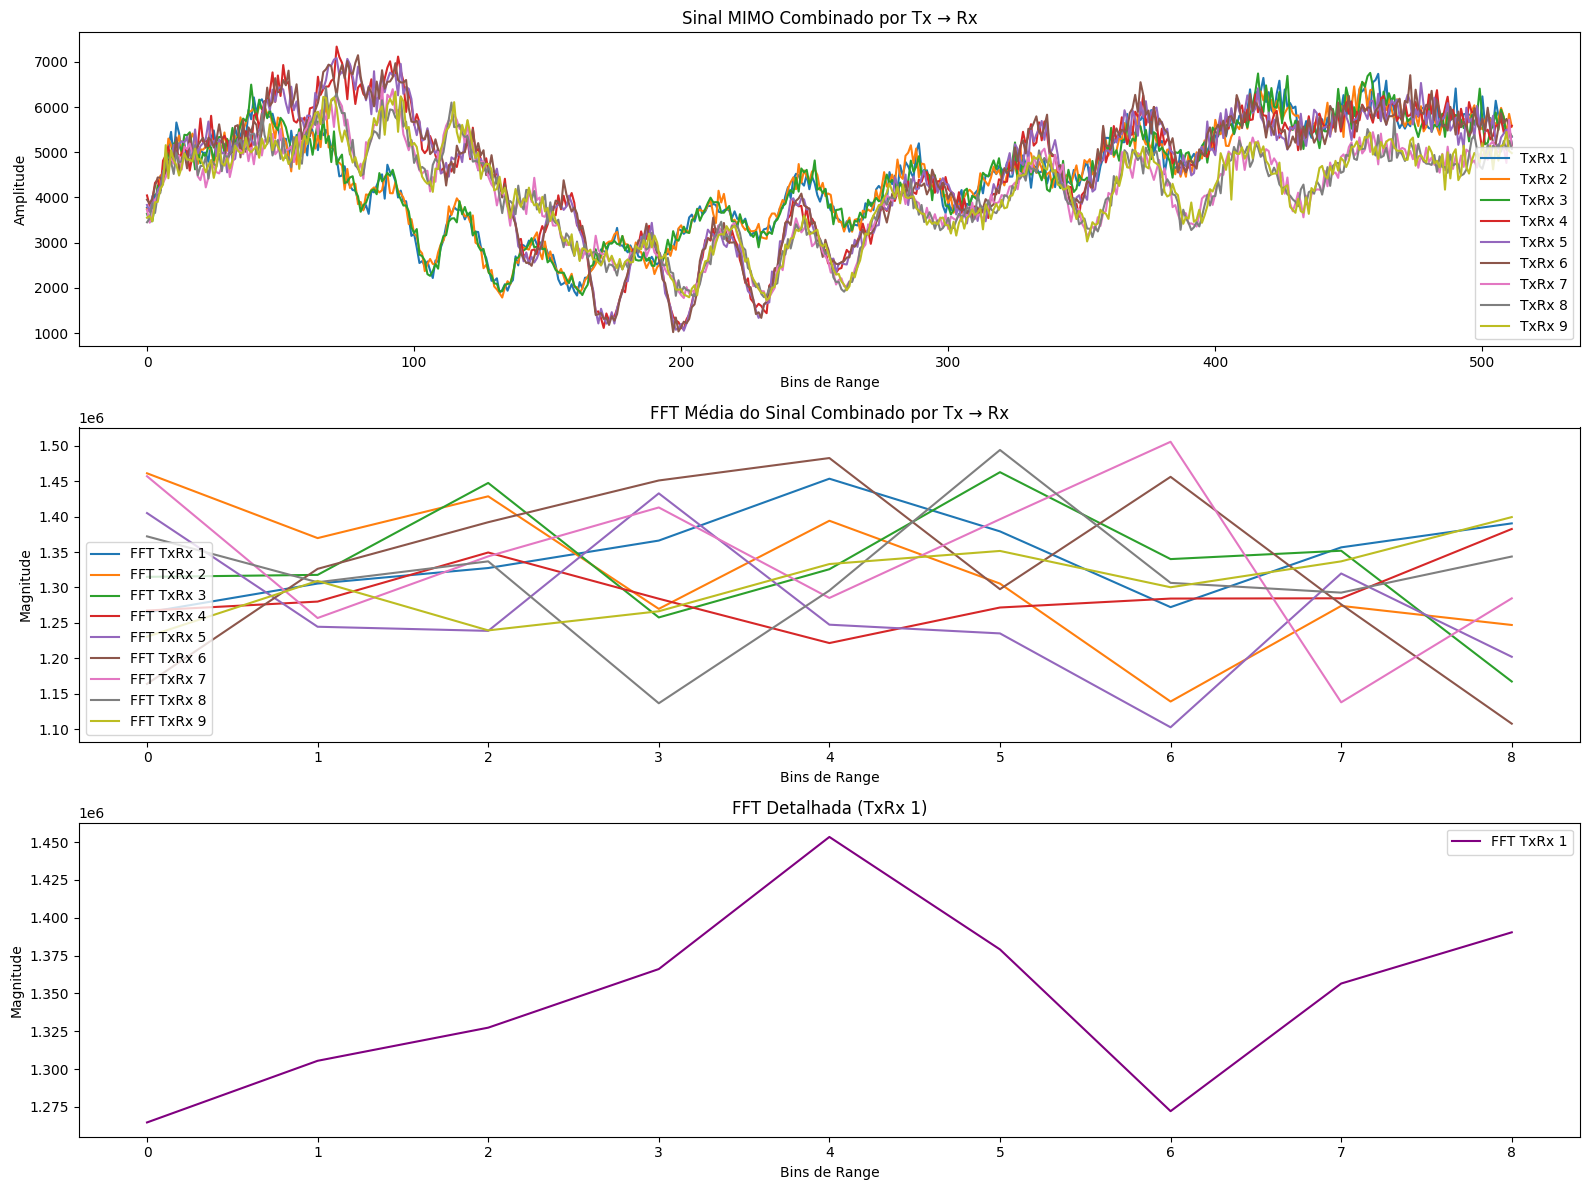

In [37]:
plt.figure(figsize=(16, 12))

# Gráfico 1: Sinal combinado MIMO por combinação Tx → Rx (Amplitude)
plt.subplot(3, 1, 1)
for idx in range(num_tx * num_rx):  # Iterar pelas combinações Tx → Rx
    label = f'TxRx {idx+1}'
    plt.plot(np.mean(np.abs(combined_mimo_signal[:, :, idx, 0]), axis=0), label=label)
plt.title('Sinal MIMO Combinado por Tx → Rx')
plt.xlabel('Bins de Range')
plt.ylabel('Amplitude')
plt.legend()

# Gráfico 2: Magnitude FFT para cada combinação Tx → Rx
plt.subplot(3, 1, 2)
fft_magnitude_reduced = fft_combined_signal.mean(axis=3)  # Média sobre bins de elevação
for idx in range(num_tx * num_rx):  # Iterar pelas combinações Tx → Rx
    label = f'FFT TxRx {idx+1}'
    plt.plot(fft_magnitude_reduced[:, idx].mean(axis=0), label=label)
plt.title('FFT Média do Sinal Combinado por Tx → Rx')
plt.xlabel('Bins de Range')
plt.ylabel('Magnitude')
plt.legend()

# Gráfico 3: FFT Detalhada de uma combinação específica
idx = 0  # Escolher uma combinação específica (TxRx 1)
plt.subplot(3, 1, 3)
plt.plot(fft_magnitude_reduced[:, idx].mean(axis=0), color='purple', label=f'FFT TxRx {idx+1}')
plt.title(f'FFT Detalhada (TxRx {idx+1})')
plt.xlabel('Bins de Range')
plt.ylabel('Magnitude')
plt.legend()

plt.tight_layout()
plt.show()